In [1]:
# Calculating heatwaves for Resiliency

In [1]:
import xarray as xr
import numpy as np
import cftime
import intake_esgf
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Set the matplotlib default font size
mpl.rcParams['font.size'] = 16

In [2]:
# read data
df= pd.read_csv('railonly.csv')
df_nodes = df[['dms_orig_string','dms_orig_coordinates']].drop_duplicates()
# Separate into latitude and longitude columns
df_nodes[['longitude', 'latitude']] = df_nodes['dms_orig_coordinates'].str.extract(r'\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)')
# Convert columns to numeric if needed
df_nodes['longitude'] = pd.to_numeric(df_nodes['longitude'])
df_nodes['latitude'] = pd.to_numeric(df_nodes['latitude'])
# Convert negative longitudes to 0-360 range
df_nodes['longitude'] = df_nodes['longitude'] % 360
# Reset the index
df_nodes = df_nodes.reset_index(drop=True)

## Reading Daily data

In [3]:
file_pattern = '/Users/ud4/.esgf/CMIP6/*/CCCma/CanESM5/*/r1i1p1f1/day/tasmax/gn/v20190429/*.nc'
ds_daily = xr.open_mfdataset(file_pattern)

In [4]:
# Constants
threshold_kelvin = 35 + 273.15

# Extract all coordinates as DataArray for vectorized selection
lats = xr.DataArray(df_nodes['latitude'].values, dims='points')
lons = xr.DataArray(df_nodes['longitude'].values, dims='points')

# Extract all tasmax values at once using vectorized nearest selection
tasmax_all = ds_daily['tasmax'].sel(lat=lats, lon=lons, method='nearest')


# Define time boundaries as cftime.DatetimeNoLeap
date_hist_start    = cftime.DatetimeNoLeap(1991, 1, 1)
date_hist_end      = cftime.DatetimeNoLeap(2020, 12, 31)
date_future1_start = cftime.DatetimeNoLeap(2021, 1, 1)
date_future1_end   = cftime.DatetimeNoLeap(2050, 12, 31)
date_future2_start = cftime.DatetimeNoLeap(2051, 1, 1)
date_future2_end   = cftime.DatetimeNoLeap(2080, 12, 31)
date_future3_start = cftime.DatetimeNoLeap(2121, 1, 1)
date_future3_end   = cftime.DatetimeNoLeap(2150, 12, 31)

# Create masks
mask_hist     = (tasmax_all['time'] > date_hist_start) & (tasmax_all['time'] <= date_hist_end)
mask_future1  = (tasmax_all['time'] > date_future1_start) & (tasmax_all['time'] <= date_future1_end)
mask_future2  = (tasmax_all['time'] > date_future2_start) & (tasmax_all['time'] <= date_future2_end)
mask_future3  = (tasmax_all['time'] > date_future3_start) & (tasmax_all['time'] <= date_future3_end)


# Boolean arrays: days above threshold
hot_days_all = tasmax_all > threshold_kelvin


# Compute counts per point
hot_days_hist = hot_days_all.sel(time=mask_hist).sum(dim='time')
hot_days_future1 = hot_days_all.sel(time=mask_future1).sum(dim='time')
hot_days_future2 = hot_days_all.sel(time=mask_future2).sum(dim='time')
hot_days_future3 = hot_days_all.sel(time=mask_future3).sum(dim='time')

# Convert to lists if needed
list_hot_days_hist = hot_days_hist.values.tolist()
list_hot_days_future = hot_days_future1.values.tolist()
list_hot_days_future2 = hot_days_future2.values.tolist()
list_hot_days_future3 = hot_days_future3.values.tolist()

In [5]:
df_nodes_daily = df_nodes.copy(deep=True)
df_nodes_daily ['hot_days_hist'] = list_hot_days_hist
df_nodes_daily ['hot_days_future'] = list_hot_days_future
df_nodes_daily ['hot_days_future2'] = list_hot_days_future2
df_nodes_daily ['hot_days_future3'] = list_hot_days_future3
# Calculate the change in the number of hot days
df_nodes_daily['hot_days_change'] = df_nodes_daily['hot_days_future'] - df_nodes_daily['hot_days_hist']
df_nodes_daily['hot_days_change2'] = df_nodes_daily['hot_days_future2'] - df_nodes_daily['hot_days_hist']
df_nodes_daily['hot_days_change3'] = df_nodes_daily['hot_days_future3'] - df_nodes_daily['hot_days_hist']
df_nodes_daily.to_csv("hot_days_daily.csv")

## Average of LOCA CMIP6 Models

In [33]:
list_ESMs = ["ACCESS-ESM1-5", "CanESM5", "GFDL-ESM4", "INM-CM5-0",
             "IPSL-CM6A-LR", "MIROC6", "MPI-ESM1-2-HR", "NorESM2-LM"
            ]
path_files_hot_days = {}
for esm in list_ESMs:
    path_files_hot_days[esm] = f"LOCA2/{esm}_hot_days_daily.csv"
    
dict_df_ESM = {}
for esm in list_ESMs:
    df_heatwave = pd.read_csv(path_files_hot_days[esm])
    dict_df_ESM[esm] = df_heatwave
    print (esm, df_heatwave.shape)

ACCESS-ESM1-5 (82, 10)
CanESM5 (82, 10)
GFDL-ESM4 (82, 10)
INM-CM5-0 (82, 10)
IPSL-CM6A-LR (82, 10)
MIROC6 (82, 10)
MPI-ESM1-2-HR (82, 10)
NorESM2-LM (82, 10)


In [36]:
# Combine all dataframes from the dictionary
combined_df = pd.concat(dict_df_ESM.values(), ignore_index=True)
# Group by coordinates and calculate means
result = (combined_df
          .groupby(['Unnamed: 0','latitude', 'longitude'], as_index=False)[['hot_days_change', 'hot_days_change2']]
          .mean())
# Select final columns
final_result = result[['latitude', 'longitude', 'hot_days_change', 'hot_days_change2']]


In [37]:
print (final_result.shape)

(82, 4)


In [38]:
set(df_nodes_daily['longitude']) == set(final_result['longitude'])


False

In [39]:
df_nodes_daily['longitude']

0     286.245032
1     275.609736
2     262.256301
3     283.389241
4     277.497723
         ...    
77    283.713600
78    282.963457
79    282.963457
80    262.662455
81    252.431466
Name: longitude, Length: 82, dtype: float64

In [50]:
final_result.summary

AttributeError: 'DataFrame' object has no attribute 'summary'

In [58]:
final_result['hot_days_change2'].max()

2485.0

In [11]:
dict_df_ESM

{'ACCESS-ESM1-5':     Unnamed: 0                         dms_orig_string  \
 0            0                     Albany NY  CFS Area   
 1            1                              Atlanta GA   
 2            2                               Austin TX   
 3            3                            Baltimore MD   
 4            4                          Baton Rouge LA   
 ..         ...                                     ...   
 77          77  Virginia Beach-Norfolk VA-NC (VA Part)   
 78          78        Washington DC-VA-MD-WV (MD Part)   
 79          79        Washington DC-VA-MD-WV (VA Part)   
 80          80                              Wichita KS   
 81          81                                 Wyoming   
 
          dms_orig_coordinates   longitude   latitude  hot_days_hist  \
 0    (-73.754968, 42.6511674)  286.245032  42.651167             50   
 1   (-84.3902644, 33.7489924)  275.609736  33.748992            287   
 2   (-97.7436995, 30.2711286)  262.256301  30.271129    

In [6]:
df_nodes_daily

,dms_orig_string,dms_orig_coordinates,longitude,latitude,hot_days_hist,hot_days_future,hot_days_future2,hot_days_future3,hot_days_change,hot_days_change2,hot_days_change3
0,Albany NY CFS Area,"(-73.754968, 42.6511674)",286.245032,42.651167,5,57,342,2497,52,337,2492
1,Atlanta GA,"(-84.3902644, 33.7489924)",275.609736,33.748992,189,554,1186,4143,365,997,3954
2,Austin TX,"(-97.7436995, 30.2711286)",262.256301,30.271129,1733,3225,4508,7433,1492,2775,5700
3,Baltimore MD,"(-76.610759, 39.2908816)",283.389241,39.290882,67,255,735,3294,188,668,3227
4,Baton Rouge LA,"(-82.502277, 28.2968872)",277.497723,28.296887,43,237,969,5544,194,926,5501
...,...,...,...,...,...,...,...,...,...,...,...
77,Virginia Beach-Norfolk VA-NC (VA Part),"(-76.2863999, 36.8448348)",283.713600,36.844835,80,283,763,3686,203,683,3606
78,Washington DC-VA-MD-WV (MD Part),"(-77.0365427, 38.8950368)",282.963457,38.895037,80,283,763,3686,203,683,3606
79,Washington DC-VA-MD-WV (VA Part),"(-77.0365427, 38.8950368)",282.963457,38.895037,80,283,763,3686,203,683,3606
80,Wichita KS,"(-97.3375448, 37.6922361)",262.662455,37.692236,3417,4146,4877,6447,729,1460,3030


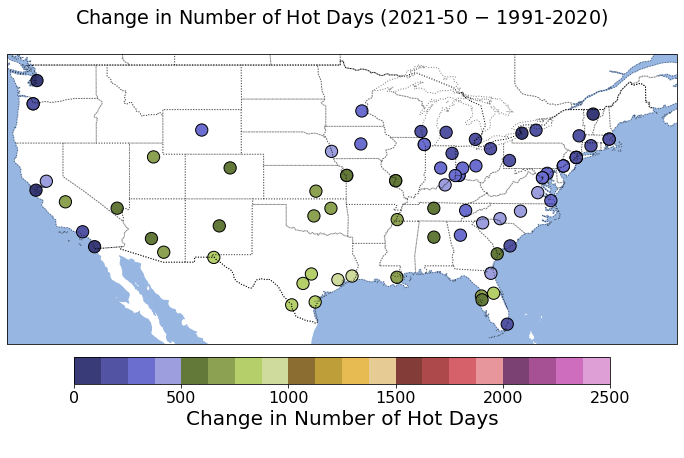

In [60]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())

#ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 2500
scatter = ax.scatter(final_result['longitude'], final_result['latitude'], 
                     c=final_result['hot_days_change'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)


# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Add titles and labels
plt.title('Change in Number of Hot Days (2021-50 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()
fig.savefig( f'plots/LOCA2_Average_Change_HotDays_2021_New.pdf',bbox_inches='tight')
fig.savefig( f'plots/LOCA2_Average_Change_HotDays_2021_New.png',bbox_inches='tight')

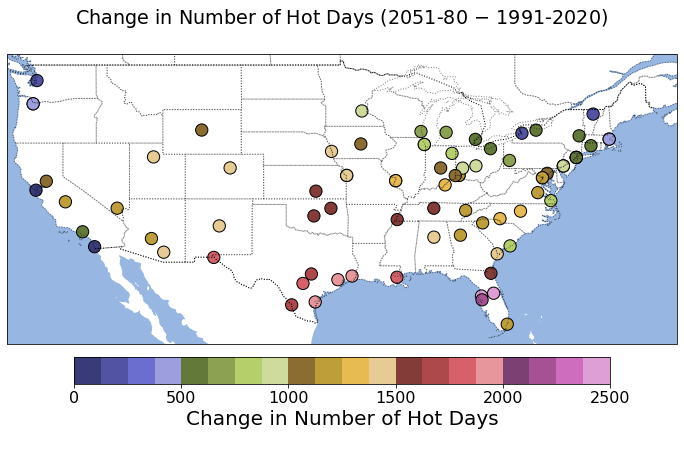

In [61]:
# Create a spatial plot of the hot days change
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent to focus on the Contiguous United States
ax.set_extent([-125, -65, 24, 50], crs=ccrs.PlateCarree())


ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle=':' , alpha =.5 )
ax.add_feature(cfeature.OCEAN, linestyle='-')

# Plot data points
vmin_val =0; vmax_val = 2500
scatter = ax.scatter(final_result['longitude'], final_result['latitude'], 
                     c=final_result['hot_days_change2'], cmap='tab20b', 
                     s=150, edgecolor='k', transform=ccrs.PlateCarree(),
                    vmin=vmin_val, vmax = vmax_val)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.03, shrink = 0.8)
cbar.set_label('Change in Number of Hot Days\n', fontsize=20)
cbar.ax.tick_params(labelsize=16)

# Add titles and labels
plt.title('Change in Number of Hot Days (2051-80 $-$ 1991-2020) \n')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

fig.savefig( f'plots/LOCA2_Average_Change_HotDays_2051_New.pdf',bbox_inches='tight')
fig.savefig( f'plots/LOCA2_Average_Change_HotDays_2051_New.png',bbox_inches='tight')

plt.show()

## end